# Segmentation

Short outline of segmentation steps:

1. Standardize data
2. Perform dimensionality reduction using PCA
3. Perform hierarchical clustering (Ward algorithm)
4. Perform K-Means (Lloyd algorithm)
5. Determine number of clusters to extract
6. Interpret created segments

In [1]:
# Import libraries
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib.colors import ListedColormap
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [ ]:
# Adjust number of columns displayed by pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
# Load and inspect datafile
df = pd.read_csv('C:/Users/nickm/Desktop/Coding/Projects/marketing-analytics-data/ifood_df.csv')
df.head()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Age,Customer_Days,marital_Divorced,marital_Married,marital_Single,marital_Together,marital_Widow,education_2n Cycle,education_Basic,education_Graduation,education_Master,education_PhD,MntTotal,MntRegularProds,AcceptedCmpOverall
0,58138.00,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1,63,2822,0,0,1,0,0,0,0,1,0,0,1529,1441,0
1,46344.00,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0,66,2272,0,0,1,0,0,0,0,1,0,0,21,15,0
2,71613.00,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0,55,2471,0,0,0,1,0,0,0,1,0,0,734,692,0
3,26646.00,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0,36,2298,0,0,0,1,0,0,0,1,0,0,48,43,0
4,58293.00,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0,39,2320,0,1,0,0,0,0,0,0,0,1,407,392,0


## Standardizing Data (Z-scores)

In [3]:
# Select variables for cluster analysis
clu_df = df.drop(['Z_CostContact', 'Z_Revenue', 'MntTotal', 'MntRegularProds', 'AcceptedCmpOverall'], axis=1)
clu_df.describe()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Customer_Days,marital_Divorced,marital_Married,marital_Single,marital_Together,marital_Widow,education_2n Cycle,education_Basic,education_Graduation,education_Master,education_PhD
count,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00
mean,51622.09,0.44,0.51,49.01,306.16,26.40,165.31,37.76,27.13,44.06,2.32,4.10,2.65,5.82,5.34,0.07,0.07,0.07,0.06,0.01,0.01,0.15,51.10,2512.72,0.10,0.39,0.22,0.26,0.03,0.09,0.02,0.50,0.17,0.22
std,20713.06,0.54,0.54,28.93,337.49,39.78,217.78,54.82,41.13,51.74,1.89,2.74,2.80,3.24,2.41,0.26,0.26,0.26,0.25,0.12,0.09,0.36,11.71,202.56,0.31,0.49,0.41,0.44,0.18,0.29,0.15,0.50,0.37,0.41
min,1730.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,24.00,2159.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,35196.00,0.00,0.00,24.00,24.00,2.00,16.00,3.00,1.00,9.00,1.00,2.00,0.00,3.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,43.00,2339.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,51287.00,0.00,0.00,49.00,178.00,8.00,68.00,12.00,8.00,25.00,2.00,4.00,2.00,5.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,50.00,2515.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
75%,68281.00,1.00,1.00,74.00,507.00,33.00,232.00,50.00,34.00,56.00,3.00,6.00,4.00,8.00,7.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,61.00,2688.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00
max,113734.00,2.00,2.00,99.00,1493.00,199.00,1725.00,259.00,262.00,321.00,15.00,27.00,28.00,13.00,20.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,80.00,2858.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [4]:
# Subtract each column by its mean and divide by standard deviation
std_clu_df = clu_df.sub(clu_df.mean()).div(clu_df.std())
# ...should result in all variables having mean=0 and std=1
std_clu_df.describe()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Customer_Days,marital_Divorced,marital_Married,marital_Single,marital_Together,marital_Widow,education_2n Cycle,education_Basic,education_Graduation,education_Master,education_PhD
count,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00
mean,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-2.41,-0.82,-0.93,-1.69,-0.91,-0.66,-0.76,-0.69,-0.66,-0.85,-1.23,-1.50,-0.95,-1.80,-2.21,-0.28,-0.28,-0.28,-0.26,-0.12,-0.10,-0.42,-2.31,-1.75,-0.34,-0.79,-0.53,-0.59,-0.19,-0.31,-0.16,-1.01,-0.44,-0.52
25%,-0.79,-0.82,-0.93,-0.86,-0.84,-0.61,-0.69,-0.63,-0.64,-0.68,-0.70,-0.77,-0.95,-0.87,-0.97,-0.28,-0.28,-0.28,-0.26,-0.12,-0.10,-0.42,-0.69,-0.86,-0.34,-0.79,-0.53,-0.59,-0.19,-0.31,-0.16,-1.01,-0.44,-0.52
50%,-0.02,-0.82,-0.93,-0.00,-0.38,-0.46,-0.45,-0.47,-0.47,-0.37,-0.17,-0.04,-0.23,-0.25,0.27,-0.28,-0.28,-0.28,-0.26,-0.12,-0.10,-0.42,-0.09,0.01,-0.34,-0.79,-0.53,-0.59,-0.19,-0.31,-0.16,0.99,-0.44,-0.52
75%,0.80,1.04,0.91,0.86,0.60,0.17,0.31,0.22,0.17,0.23,0.36,0.69,0.48,0.67,0.69,-0.28,-0.28,-0.28,-0.26,-0.12,-0.10,-0.42,0.85,0.87,-0.34,1.26,-0.53,1.70,-0.19,-0.31,-0.16,0.99,-0.44,-0.52
max,3.00,2.90,2.74,1.73,3.52,4.34,7.16,4.04,5.71,5.35,6.72,8.37,9.06,2.21,6.08,3.54,3.53,3.56,3.81,8.51,10.45,2.37,2.47,1.70,2.93,1.26,1.90,1.70,5.29,3.18,6.31,0.99,2.25,1.91


## Dimensionality Reduction with Principal Component Analysis

In [5]:
# perform pca with 2 components
pca = PCA(n_components=2, random_state=42)
result = pca.fit(std_clu_df)

In [6]:
# observe explained variance by the 2 components
result.explained_variance_

array([6.91705153, 2.26790228])

In [7]:
# show loading matrix
loadings = result.components_.T * np.sqrt(result.explained_variance_)
loadings = pd.DataFrame(loadings, index=clu_df.columns, columns=['comp1', 'comp2'])
loadings.sort_values(by=['comp1', 'comp2'], ascending=[False, False])

,comp1,comp2
Income,0.88,0.11
NumCatalogPurchases,0.84,0.02
MntMeatProducts,0.82,-0.19
MntWines,0.79,0.30
NumStorePurchases,0.74,0.23
MntFishProducts,0.70,-0.24
MntSweetProducts,0.69,-0.20
MntFruits,0.68,-0.23
MntGoldProds,0.57,0.05
NumWebPurchases,0.55,0.46


In [8]:
# extract factor scores
clu_df[['comp1', 'comp2']] = pca.fit_transform(std_clu_df)
clu_df[['comp1', 'comp2']].head()

,comp1,comp2
0,3.89,-0.57
1,-2.36,-0.53
2,1.72,-0.34
3,-2.62,-1.59
4,-0.47,0.16


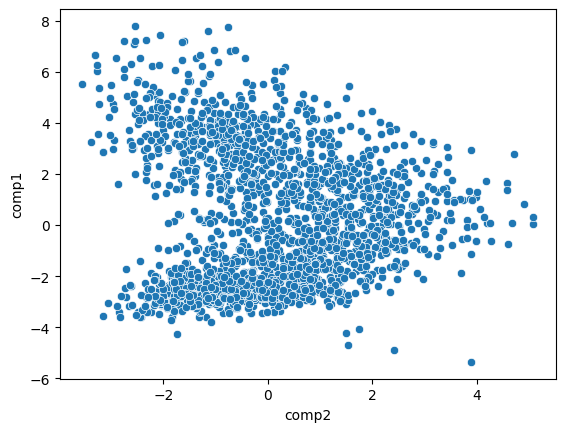

In [9]:
# visualize extracted scores in 2-dimensional space
sns.scatterplot(y=clu_df['comp1'], x=clu_df['comp2']);

## K-Means Clustering

In [10]:
np.random.seed(42)

inertia = []
labels = []
silhouette = []

for k in range(2,13):
    # define data
    X = clu_df.filter(['comp1', 'comp2'])

    # perform hierarchical clustering
    agg_clu_model = AgglomerativeClustering(n_clusters=k, linkage='ward')
    X['agg_clu'] = agg_clu_model.fit_predict(X)
    # store resulting cluster centers used as initial centroids in k-means
    centroids = X.groupby('agg_clu').mean()

    # perform k-means clustering, select centroids from hierarchical clustering for initialization
    kmeans = KMeans(n_clusters=k, n_init=1, init=centroids, random_state=42)
    kmeans.fit(X.drop('agg_clu', axis=1))

    # store cluster allocation, inertia and silhouette scores
    labels.append(kmeans.labels_)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X, kmeans.labels_))

In [11]:
# show inertia values
np.array(inertia)

array([8422.6345652 , 4871.74801482, 3863.1225766 , 3166.04435693,
       2742.33375061, 2333.68620494, 2054.9247149 , 1848.36091526,
       1686.93428857, 1562.73854867, 1403.73356342])

In [12]:
# show silhouette scores
np.array(silhouette)

array([0.52673717, 0.48628488, 0.42923089, 0.39724414, 0.3718841 ,
       0.31928906, 0.30608469, 0.35401833, 0.40578937, 0.32448825,
       0.23917942])

In [13]:
# glance into cluster labels, i.e. each datapoint's allocated cluster
labels[:5]

[array([0, 1, 0, ..., 0, 0, 1]),
 array([1, 0, 1, ..., 2, 2, 2]),
 array([0, 3, 0, ..., 2, 2, 1]),
 array([1, 3, 4, ..., 4, 2, 0]),
 array([1, 3, 4, ..., 4, 2, 0])]

## Select number of clusters

### Elbow Criterion & Silhouette Scores

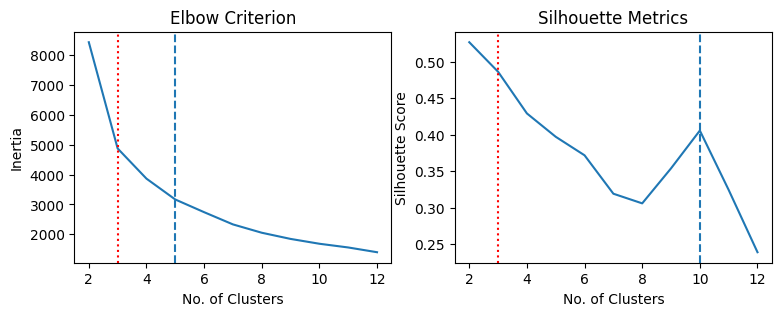

In [14]:
fig, axs = plt.subplots(figsize=(9, 3), ncols=2)

# inspect elbow criterion
sns.lineplot(x=range(2, 13), y=inertia, ax=axs[0])
axs[0].set_title('Elbow Criterion')
axs[0].set_ylabel('Inertia')
axs[0].set_xlabel('No. of Clusters')
axs[0].axvline(5, linestyle='--')
axs[0].axvline(3, linestyle='dotted', color='red')

# inspect silhouette metrics
sns.lineplot(x=range(2, 13), y=silhouette, ax=axs[1])
axs[1].set_title('Silhouette Metrics')
axs[1].set_ylabel('Silhouette Score')
axs[1].set_xlabel('No. of Clusters')
axs[1].axvline(10, linestyle='--')
axs[1].axvline(3, linestyle='dotted', color='red');

In [15]:
# inspect changes in inertia numerically
inertia_difs = pd.DataFrame({'change_at' : [f'{k}_clusters' for k in range(3,13)],
                             'inertia_change' : [x0-x1 for x0, x1 in zip(inertia[:-1], inertia[1:])]})
inertia_difs

,change_at,inertia_change
0,3_clusters,3550.89
1,4_clusters,1008.63
2,5_clusters,697.08
3,6_clusters,423.71
4,7_clusters,408.65
5,8_clusters,278.76
6,9_clusters,206.56
7,10_clusters,161.43
8,11_clusters,124.20
9,12_clusters,159.00


### Cluster Sizes

In [16]:
# exctract cluster sizes for each cluster solution
cluster_sizes = pd.DataFrame(np.zeros(shape=(12, 11), dtype=int))

for col, lab in enumerate(labels):
    for row in range(max(lab)+1):
        cluster_sizes.at[row,col] = sum(lab==row)

cluster_sizes.index = [f'cluster_{c}' for c in range(1,13)]
cluster_sizes.columns = [f'{c}_clusters' for c in range(2,13)]

cluster_sizes.iloc[:6,:4]

,2_clusters,3_clusters,4_clusters,5_clusters
cluster_1,874,1003,524,501
cluster_2,1331,566,532,303
cluster_3,0,636,448,375
cluster_4,0,0,701,667
cluster_5,0,0,0,359
cluster_6,0,0,0,0


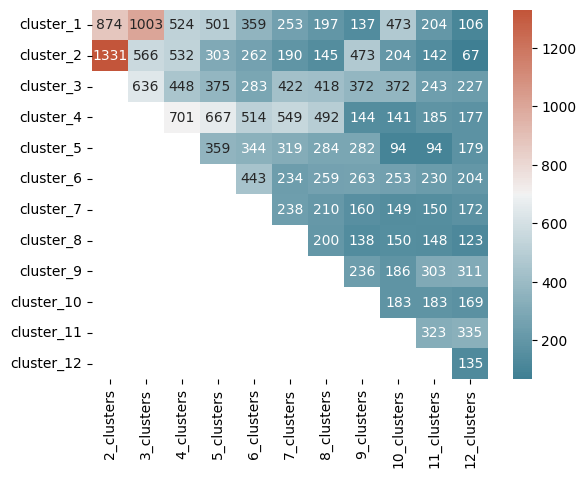

In [17]:
sns.heatmap(cluster_sizes.where(cluster_sizes != 0), 
            annot=True, 
            fmt='.0f', 
            cmap=sns.diverging_palette(220, 20, n=200));

### Graphical Representation of Cluster Allocation

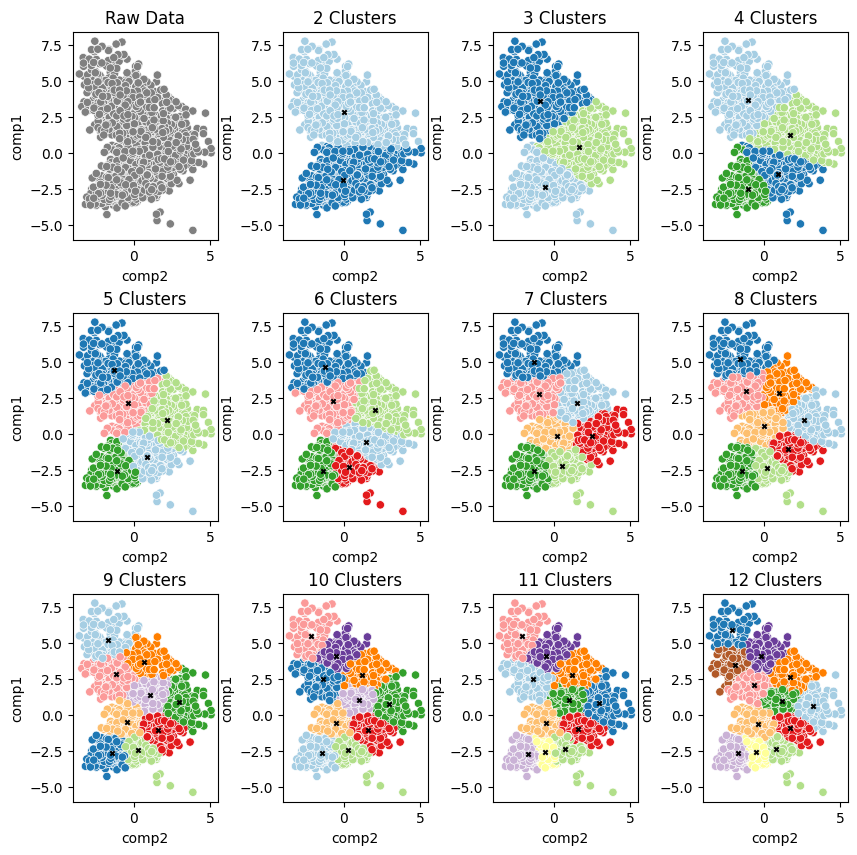

In [18]:
fig, axs = plt.subplots(figsize=(10,10), ncols=4, nrows=3)
plt.subplots_adjust(wspace=0.45, hspace=0.35)
axs = axs.ravel()

# display data without segmentation
sns.scatterplot(y=clu_df['comp1'], x=clu_df['comp2'], ax=axs[0], hue=1, palette=['grey'], legend=False)
axs[0].set_title('Raw Data')

for k in range(len(labels)):
    # color in datapoints according to cluster allocation
    sns.scatterplot(y=clu_df['comp1'],
                    x=clu_df['comp2'],
                    hue=labels[k],
                    ax=axs[k+1],
                    palette=sns.color_palette('Paired', n_colors=k+2),
                    legend=False)
    # add cluster centers
    axs[k+1].scatter(y=clu_df.groupby(labels[k]).mean()['comp1'],
                     x=clu_df.groupby(labels[k]).mean()['comp2'],
                     c='black',
                     s=10,
                     marker='x')
    axs[k+1].set_title(f'{k+2} Clusters');

### Conclusion

- The elbow criterion points to a solution with 3, 4 or 5 clusters.
- Looking at the silhouette scores, solutions with 2, 3, 4 or 10 clusters stick out.

For the sake of interpretability, the lowest common suggestion will be used: the solution with 3 clusters

## Cluster interpretation

In [19]:
# use solution with 3 clusters
pd.Series(labels[1]).value_counts()

0    1003
2     636
1     566
Name: count, dtype: int64

In [20]:
# add cluster allocation to dataset
clu_df['cluster_label'] = labels[1]

In [21]:
# determine cluster centers, i.e. variable means in each cluster
cluster_centers = clu_df.drop(['comp1', 'comp2'], axis=1).groupby('cluster_label').mean().T
cluster_centers.head()

cluster_label,0,1,2
Income,34088.37,75900.75,57667.07
Kidhome,0.80,0.04,0.23
Teenhome,0.43,0.18,0.92
Recency,49.28,49.53,48.11
MntWines,40.43,605.99,458.41


In [22]:
# sort clusters by Income so that highest income appears in first column
cluster_centers = cluster_centers.T.sort_values('Income', ascending=False).T
cluster_centers.head()

cluster_label,1,2,0
Income,75900.75,57667.07,34088.37
Kidhome,0.04,0.23,0.80
Teenhome,0.18,0.92,0.43
Recency,49.53,48.11,49.28
MntWines,605.99,458.41,40.43


In [23]:
# In order to compare the clusters, I will display the cluster centers as a heatmap.
# To ease detection of differences between clusters (i.e., their means), the dataframe 
#  will be standardized row-wise by dividing by its maximum value.
cluster_center_stand = cluster_centers.div(cluster_centers.max(axis=1), axis=0)
cluster_center_stand.head()

cluster_label,1,2,0
Income,1.00,0.76,0.45
Kidhome,0.06,0.28,1.00
Teenhome,0.19,1.00,0.47
Recency,1.00,0.97,0.99
MntWines,1.00,0.76,0.07


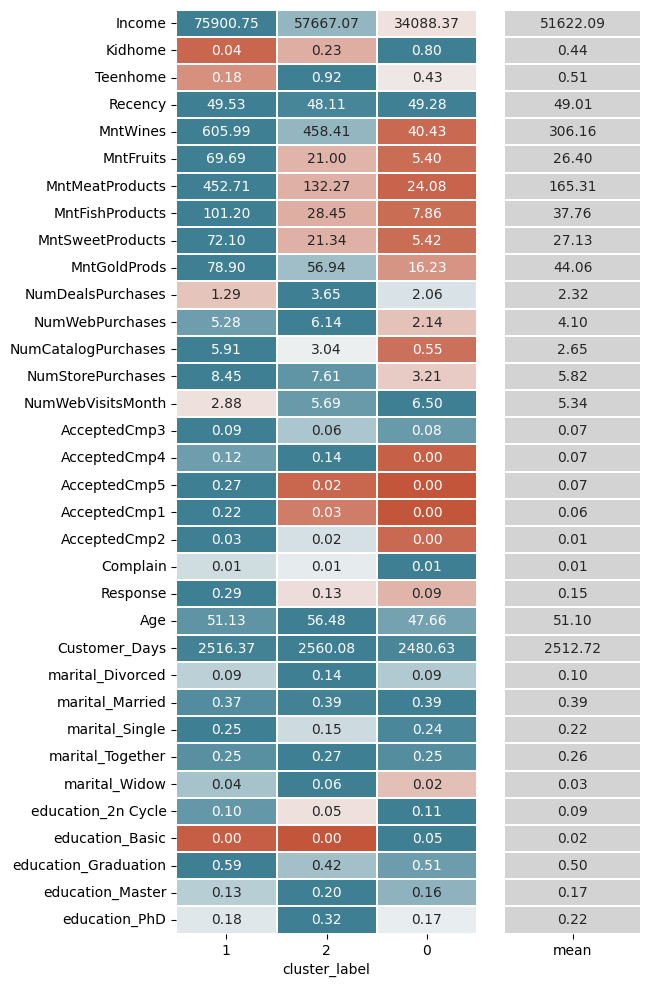

In [24]:
fig = plt.figure(figsize=(6,12))
axs = fig.subplot_mosaic('AAB')

# display cluster means (row-wise standardized; annotation refers to original values)
sns.heatmap(cluster_centers.div(cluster_centers.max(axis=1), axis=0),
            annot=cluster_centers,
            fmt='.2f',
            cbar=False,
            cmap=sns.diverging_palette(20, 220, n=200),
            linecolor='white',
            linewidths=0.1,
            ax=axs['A'])

# show global means for comparison
sns.heatmap(pd.DataFrame({'mean' : clu_df.mean()}).drop(['cluster_label', 'comp1', 'comp2'], axis=0),
            annot=True,
            fmt='.2f',
            cbar=False,
            cmap=ListedColormap(['lightgray']),
            linecolor='white',
            linewidths=0.1,
            yticklabels=False,
            ax=axs['B']);

### Details

- Cluster 1 (Wealthy, childless, and big spenders):
    - The first cluster consists of customers with higher income
    - Only a few of the has kids (at home).
    - They predominantly are in a relationship, with 37% being married and 25% being together.
    - However, there is also a large share of singles in this segment.
    - The majority of individuals in this cluster graduated college.
    - They show the highest expenditures amongst all categories as compared to the other segments.
    - With regard to shopping channels, they have the highest number of purchases in stores and via catalogs, while also showing a large number in web purchases (however, infrequent web visits). Finally, they tend to shop less for deals.
    - They respond best to all previous campaigns as well as the current one ('Response').
- Cluster 2 (Highly educated deal choppers with expensive taste - and a teenager at home):
    - Segment two is dominated by customers with teenagers at home.
    - Likewise, they are the oldest segment on average.
    - Their education levels are the highest amongst all segements, showing the largest share of individuals holding a master's and/or PhD degree.
    - They shop a lot, in store & online, and are also the most deal-driven consumers in our sample.
    - Interestingly, the amounts spent on wines and gold products stick out.
    - These customers accepted campaign 4 more than any other segment.
    - While the majority is in a relationship (66%, of which 39% married and 27% together), they are also the segment with the largest number of divorcees (14%) and widowed people (6%) in our customer base.
- Cluster 3 (Low income, web adept, and ad adverse):
    - The third cluster is the one with the lowest income on average.
    - These customers are also the youngest while having the most kids at home.
    - Their expenditures are low and they did not respond at all to any of the campaigns 1, 2, 4 and 5; however did show some response to the third and most recent campaign.
    - Finally, this segment sticks out as the one with the most web visits in a month.

## Appendix

### Animated Visualization of Cluster Allocation

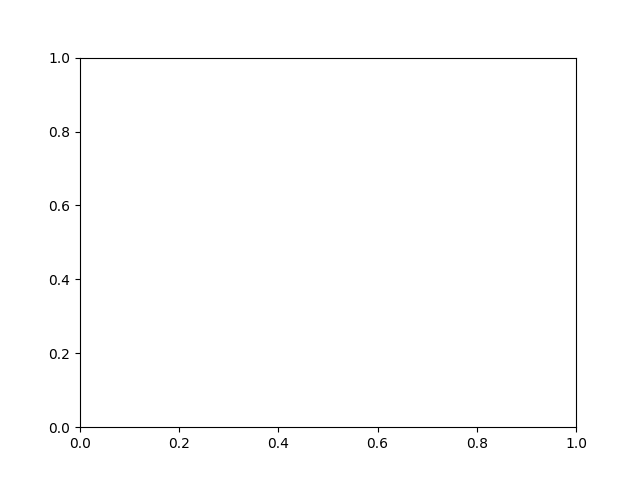

In [25]:
%matplotlib ipympl

fig, ax = plt.subplots()

def animate(i):
    ax.clear()
    ax.set_ylabel('comp1')
    ax.set_xlabel('comp2')
    ax.scatter(y=clu_df['comp1'], x=clu_df['comp2'], c=labels[i])
    ax.scatter(y=clu_df.groupby(labels[i]).mean()['comp1'],
               x=clu_df.groupby(labels[i]).mean()['comp2'], c='black', marker='x')

ani = animation.FuncAnimation(fig=fig, func=animate, frames=len(labels), interval=500)
plt.show()